# Data Processing for Logistic Regression with Linear Features

---

Our problem requires classification prediction. Logistic regression is one of the good algorithm to base our model on.

As with all regression algorithms, Logistic Regression is very sensitive to outliers and abnormal data distribution, regardless if we are using polynomial features or not. And if we are using polynomial features, feature scaling also becomes an important step in our data processing.

Thus, data processing for Logistic Regression (using either linear or polynomial features) can be summarized in the following steps:

**For training dataset:**

1. Deal with outliers;
2. Transform data into normal distribution;
3. Rescale features;
4. Feature sampling (because our training data is imbalanced as analyzed in [Step 1. EDA](../Step1.EDA.ipynb))
5. Further feature engineering to improve our model's performance...

*Note:* The target is already processed adequately in [Step 2. Data Preprocessing](../Step2.DataPreprocessing.ipynb), so there is no need to process it.

**For test dataset (would be done before using our model to predict):**
1. Transform data into normal distribution;
2. Rescale features.

In [70]:
# Imports and environment setup
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Custom utils functions
from utils.visualization import header
from utils.visualization import show_distribution
from utils.visualization import show_aggregate_distribution
from utils.visualization import show_boxplots

from utils.processing import impute_outliers_iqr


# Load our dataset
df_train = pd.read_csv("../../data/train.csv")
df_test = pd.read_csv("../../data/test.csv")

In [71]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     599 non-null    float64
 1   PL      599 non-null    float64
 2   PR      599 non-null    float64
 3   SK      599 non-null    float64
 4   TS      599 non-null    float64
 5   M11     599 non-null    float64
 6   BD2     599 non-null    float64
 7   Age     599 non-null    int64  
 8   Sepsis  599 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 42.2 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,4.418527,121.156541,71.945778,26.570043,117.798267,32.399633,0.481187,33.290484,0.347245
std,2.946267,30.763933,11.930128,9.832568,95.217445,6.968993,0.337552,11.828446,0.476492
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,64.000000,20.562604,79.460768,27.400000,0.248000,24.000000,0.000000
50%,3.824708,117.000000,70.000000,23.000000,79.460768,32.000000,0.383000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [72]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     169 non-null    int64  
 1   PL      169 non-null    int64  
 2   PR      169 non-null    int64  
 3   SK      169 non-null    int64  
 4   TS      169 non-null    int64  
 5   M11     169 non-null    float64
 6   BD2     169 non-null    float64
 7   Age     169 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 10.7 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.917160,123.520710,70.426036,20.443787,81.000000,32.249704,0.438876,33.065089
std,3.402415,29.259123,19.426805,15.764962,110.720852,7.444886,0.306935,11.548110
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.600000,0.223000,24.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.343000,28.000000
75%,6.000000,141.000000,80.000000,32.000000,135.000000,36.600000,0.587000,42.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000


## 1. Baseline Model

We are going to set up a baseline Logistic Regression model. Note: We are only using linear features here for simplicity, and will optimize our model by trying polynomial features later on when we focus on developing our logistic regression model.


We will be using [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to measure our model's performance and optimize it. While every sepsis case needs immediate attention, thus every potential sepsis patient needs close monitering, false positive predictions might take medical resources away from patients that might actually need it. In subsequent model development, if we see that recall and precision have different weights in our problem domain, we can switch to [F-beta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#:~:text=The%20F-beta%20score%20is,recall%20in%20the%20combined%20score.) instead.

There will be no regularization to keep things simple, since at this point we only care about how to best process our data. Regularization will be introduced later when we focus on fine-tuning our model.

This baseline model will be trained on raw training data and its performance would be the baseline for us to find out how to best process our data. Since our training dataset is small (599 datapoints), K-fold cross validation is the best option to validate our model's performance. With that said, here we are not trying to find the best model, but the best data processing scheme for our Logistic Regression model. Thus, we will be using simple holdout cross validation.

**Note:** Reproducibility of our results is important in this context.

Separate our features (X) and target (Y):

In [73]:
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

In [74]:
df_X.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,6.000000,148.0,72.0,35.000000,79.460768,33.6,0.627,50
1,1.000000,85.0,66.0,29.000000,79.460768,26.6,0.351,31
2,8.000000,183.0,64.0,20.562604,79.460768,23.3,0.672,32
3,1.000000,89.0,66.0,23.000000,94.000000,28.1,0.167,21
4,3.824708,137.0,40.0,35.000000,168.000000,43.1,2.288,33


In [75]:
df_y.head()

,Sepsis
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0


Splitting our raw training data into a train set and a test set:

In [76]:
train_X, test_X, train_y, test_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2
)

train_y = train_y["Sepsis"].values
test_y = test_y["Sepsis"].values

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_y shape: {test_y.shape}")

train_X shape: (479, 8)
train_y shape: (479,)
test_X shape: (120, 8)
test_y shape: (120,)


Training and validating our model using cross-validation (K-fold splitting), performance measured and optimized using F1 score:

In [77]:
baseline_clf = LogisticRegression(
    penalty=None,             # No regularization
    class_weight="balanced",  # Because our training data is imbalanced
    max_iter=1_000,
    random_state=99           # Reproducible result
)

baseline_clf.fit(train_X, train_y)
pred_y = baseline_clf.predict(train_X)

In [78]:
baseline_performance_report = classification_report(train_y, pred_y)
print(f"{header(53, 'BASELINE MODEL PERFORMANCE')}\n{baseline_performance_report}")

╔═══════════════════════════════════════════════════╗
║            BASELINE MODEL PERFORMANCE             ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.80       316
         1.0       0.62      0.71      0.66       163

    accuracy                           0.75       479
   macro avg       0.73      0.74      0.73       479
weighted avg       0.76      0.75      0.76       479



Our baseline model's performance key metrics:

|                  | F1 Score |
|:-----------------|---------:|
| Negative         |     0.81 |
| Positive         |     0.69 |
| Macro Average    |     0.75 |
| Weighted Average |     0.77 |

Our model is somewhat above average at the moment. It is also better at predicting Negative cases versus Positive cases, which is undesirable for our purpose. We want it to predict both classes equally well, or at least predict the Positive class better.

Let's see if we can improve this with data processing.

## 2. Data Processing

### 2.1. Data Overview

Detailed analysis in [Step 1. EDA](../Step1.EDA.ipynb).

In [79]:
df_train.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,4.418527,121.156541,71.945778,26.570043,117.798267,32.399633,0.481187,33.290484,0.347245
std,2.946267,30.763933,11.930128,9.832568,95.217445,6.968993,0.337552,11.828446,0.476492
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,64.000000,20.562604,79.460768,27.400000,0.248000,24.000000,0.000000
50%,3.824708,117.000000,70.000000,23.000000,79.460768,32.000000,0.383000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [80]:
df_test.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.917160,123.520710,70.426036,20.443787,81.000000,32.249704,0.438876,33.065089
std,3.402415,29.259123,19.426805,15.764962,110.720852,7.444886,0.306935,11.548110
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.600000,0.223000,24.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.343000,28.000000
75%,6.000000,141.000000,80.000000,32.000000,135.000000,36.600000,0.587000,42.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000


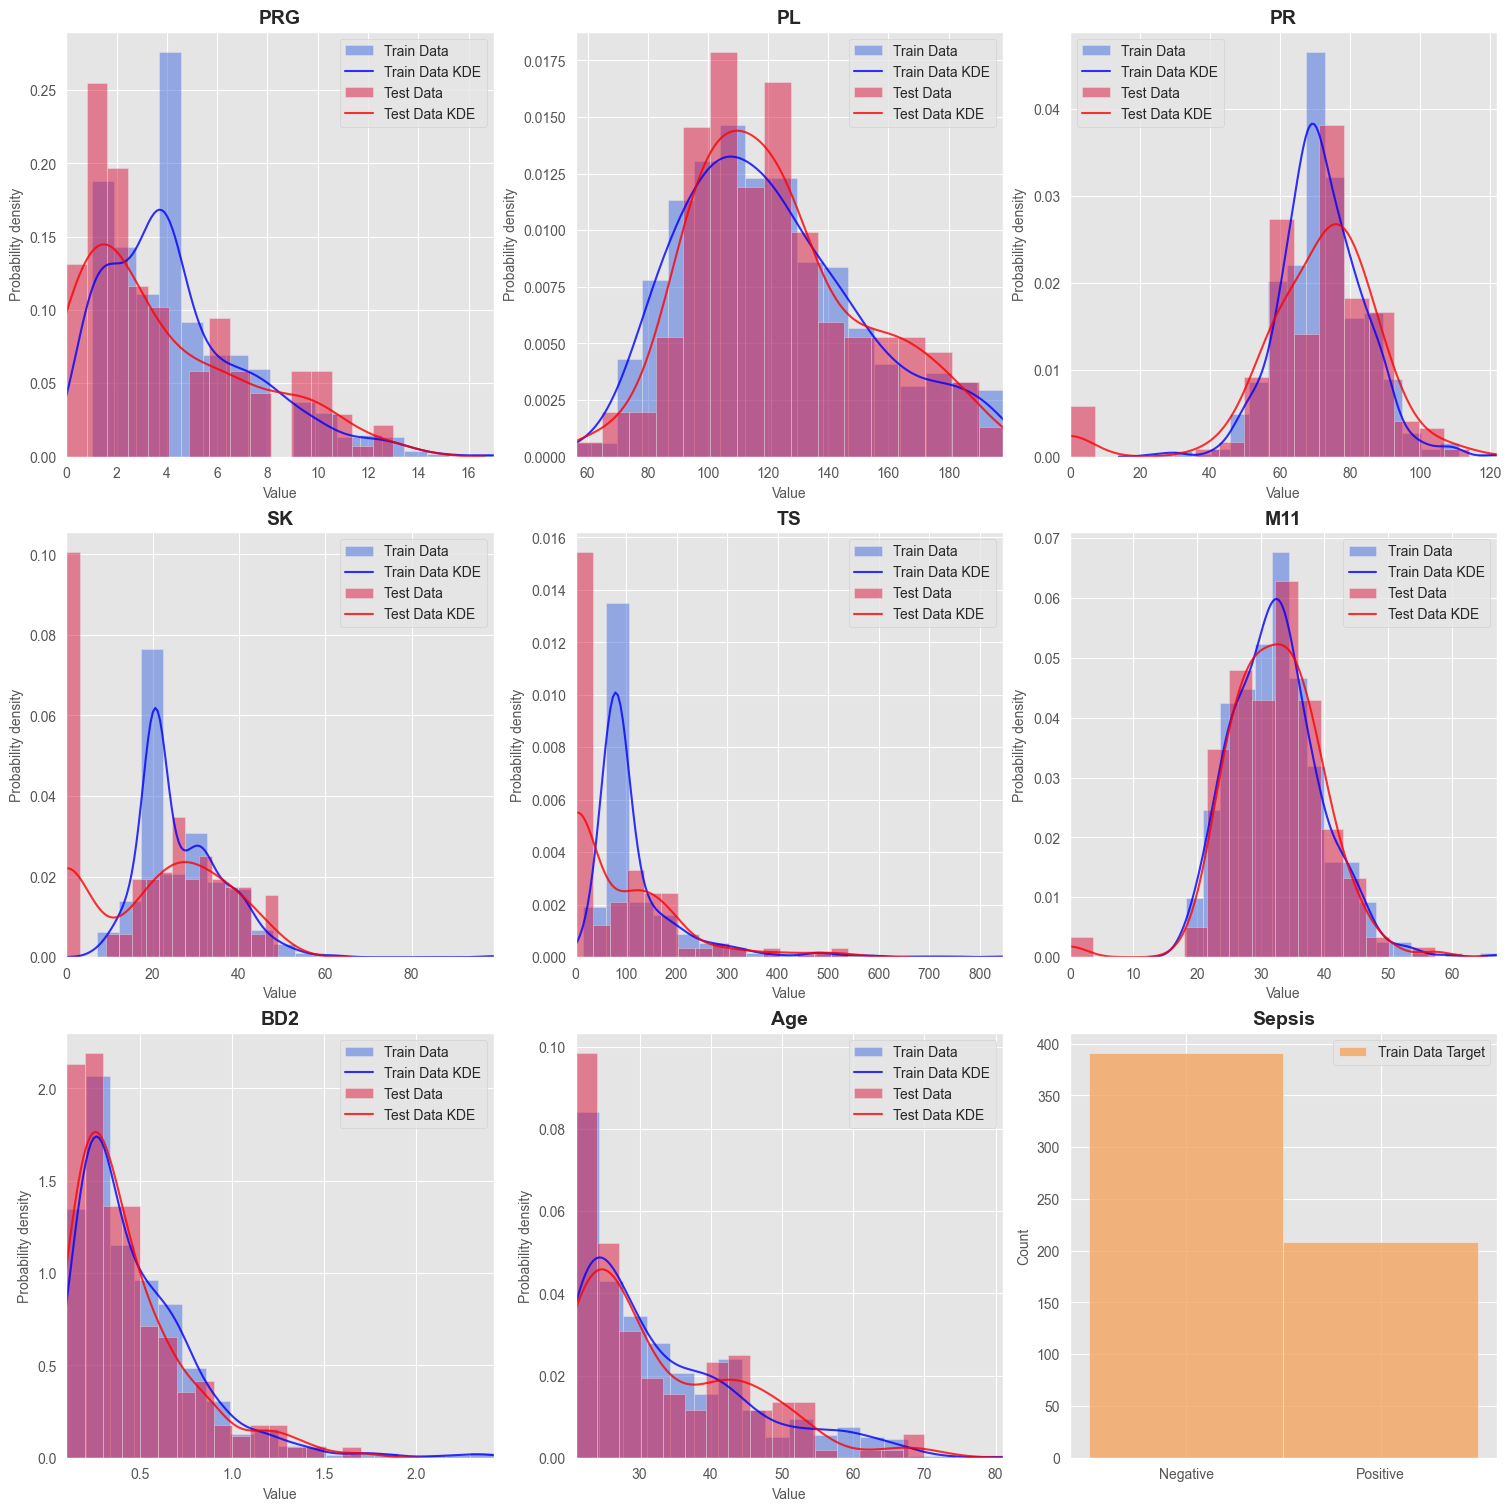

In [81]:
show_aggregate_distribution(df_train, df_test)

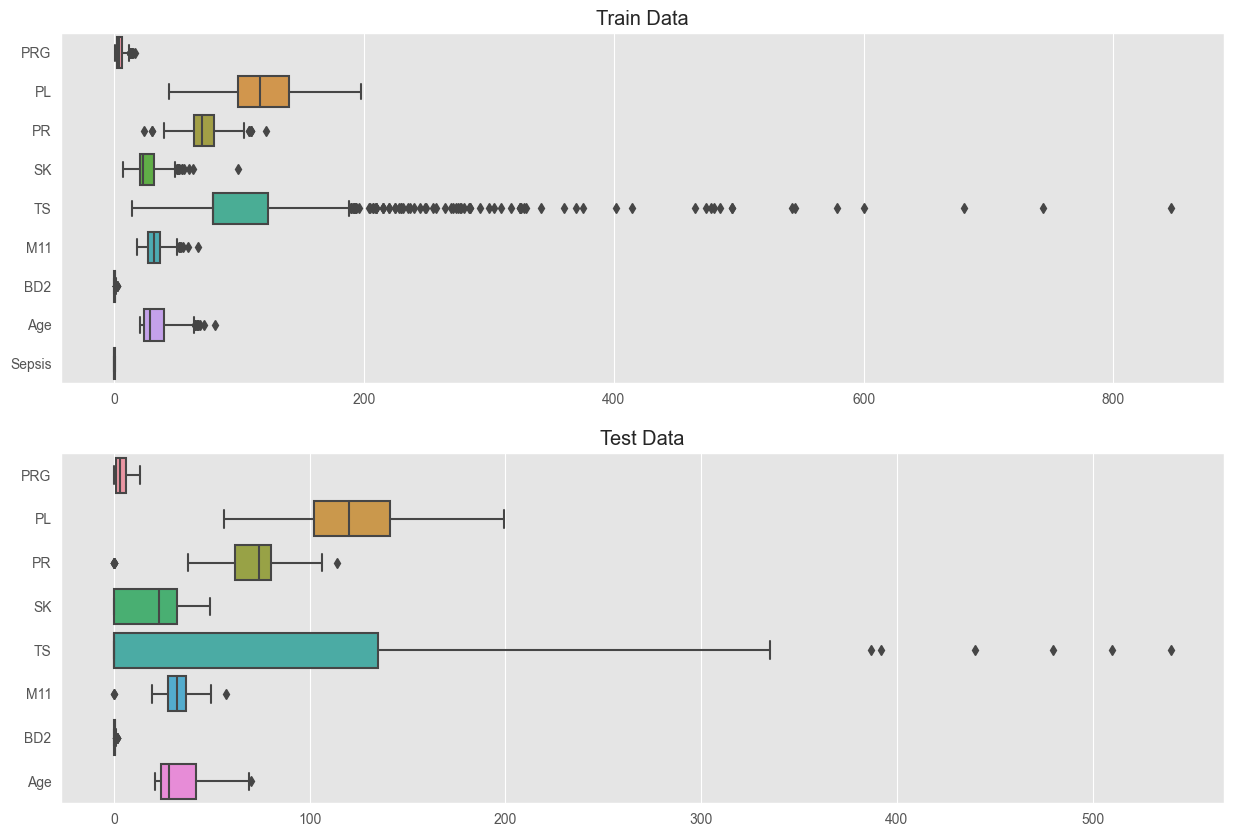

In [82]:
show_boxplots(df_train, df_test)

### 2.2. Outliers

We will impute all of these values by using k-Nearest Neighbors, so that data distribution is preserved.

In [83]:
imputer = KNNImputer(n_neighbors=50)
for col in df_train.columns:
    if col == "Sepsis":  # Target column does not have outliers, as it is categorical
        continue

    # Imputing outliers
    impute_outliers_iqr(col, df_train, imputer)

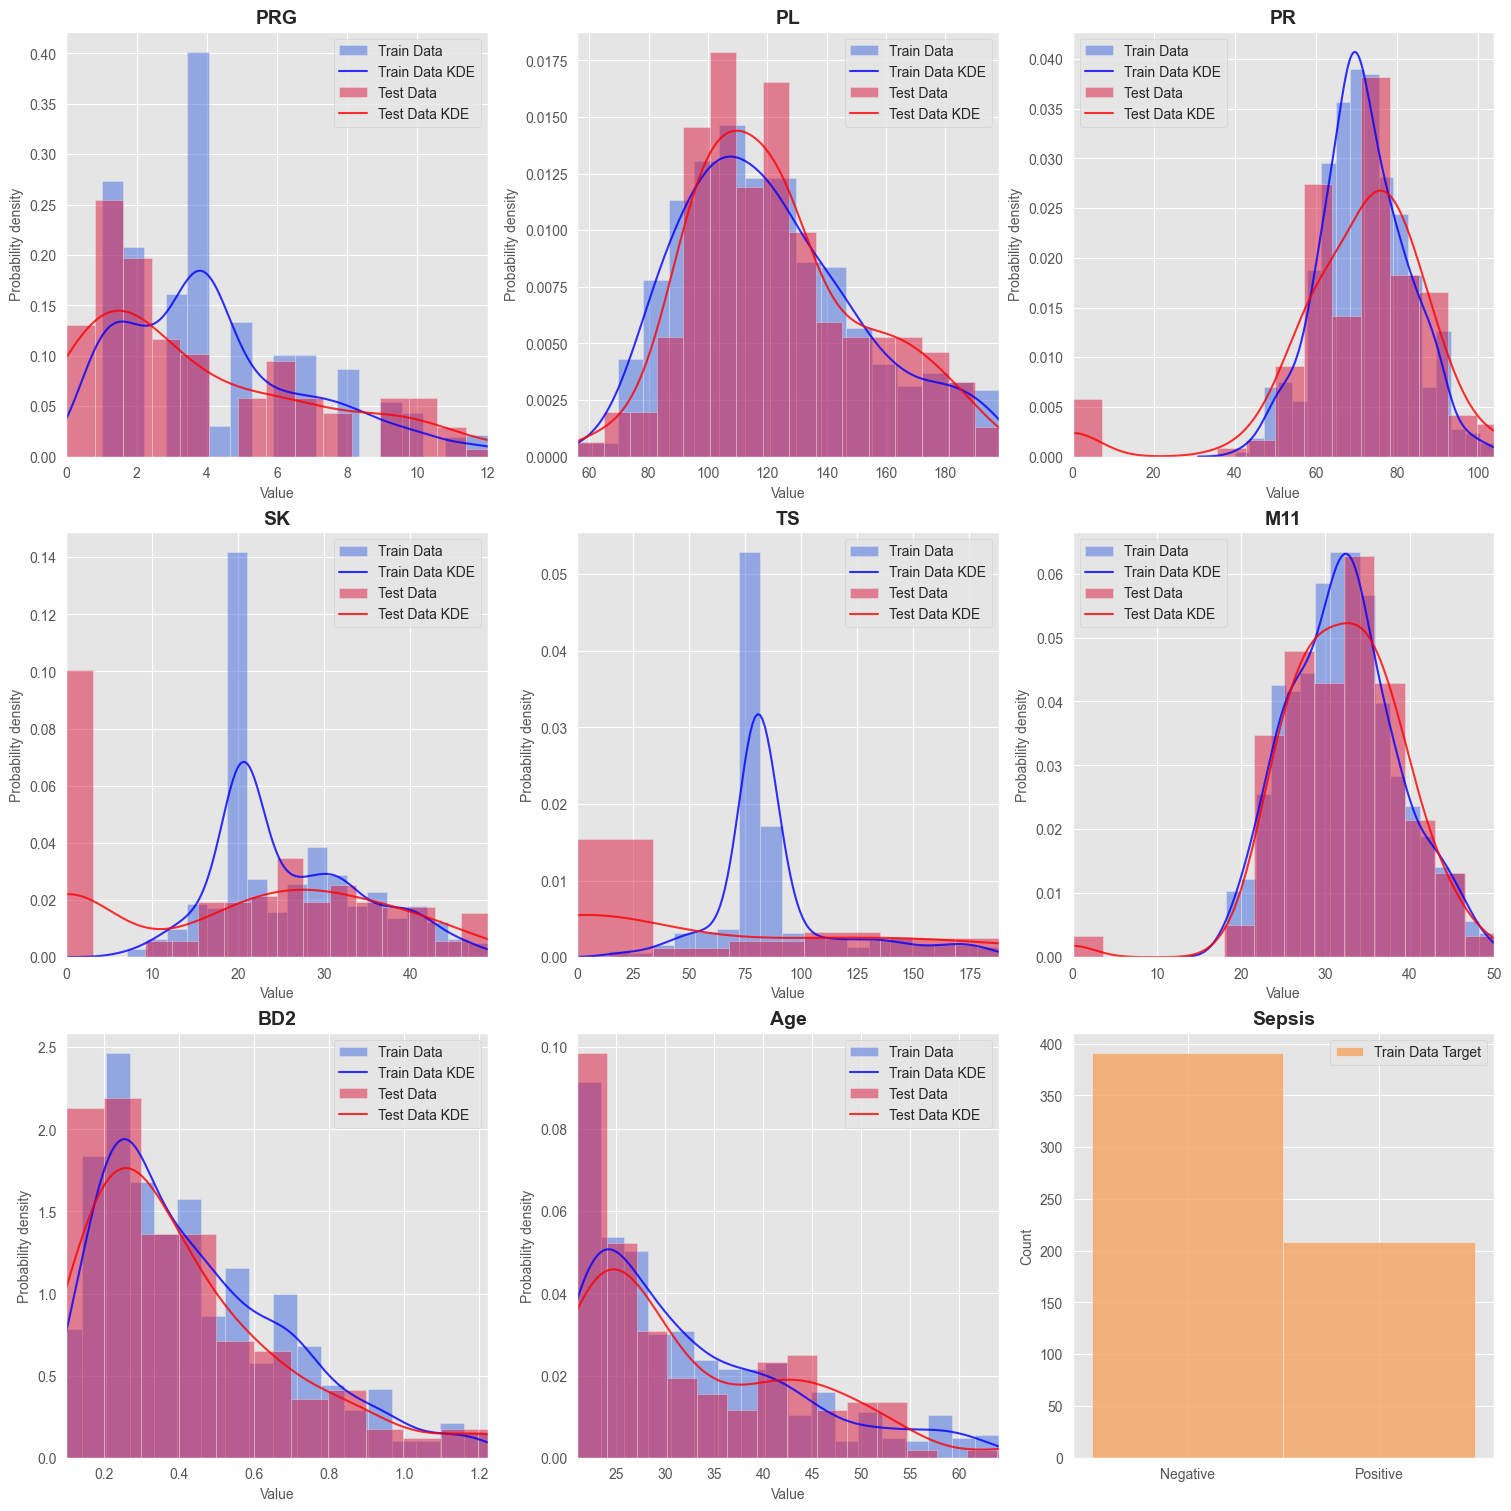

In [84]:
show_aggregate_distribution(df_train, df_test)

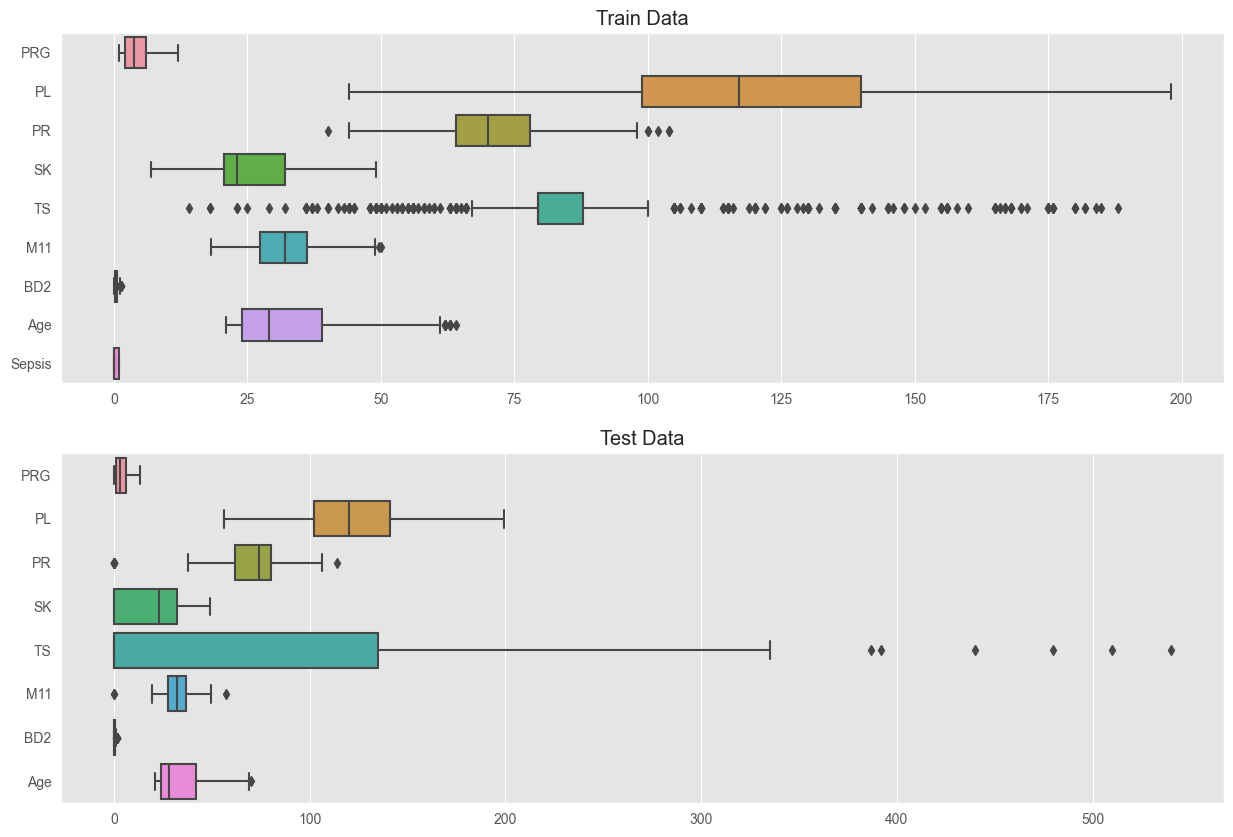

In [85]:
show_boxplots(df_train, df_test)

### 2.3. Data Transformation

We will turn the data distribution in each column into a more normal distribution using natural log transformation $x_1 = ln(x_0)$, because regression models, including Logistic Regression, work better on such distribution.

Note that we avoid taking $ln(x)$ where $x$ is close to $0$ - which approaches infinity - by adding a small constant $0.001$ to all datapoints (except for those that are exactly 0, then we just keep their values).

Then, we scale the data back later to have 0 mean and unit variance (Standardization).

In [86]:
scaler = StandardScaler()
added_const = 0.001
for col in df_train.columns:
    if col == "Sepsis":  # Target column does not need these processing
        continue

    # Transform data
    df_train[col] = np.where(df_train[col] != 0, np.log(df_train[col] + added_const), 0)
    df_test[col] = np.where(df_test[col] != 0, np.log(df_test[col] + added_const), 0)

    # Standardize data
    df_train[[col]] = scaler.fit_transform(df_train[[col]])
    df_test[[col]] = scaler.fit_transform(df_test[[col]])

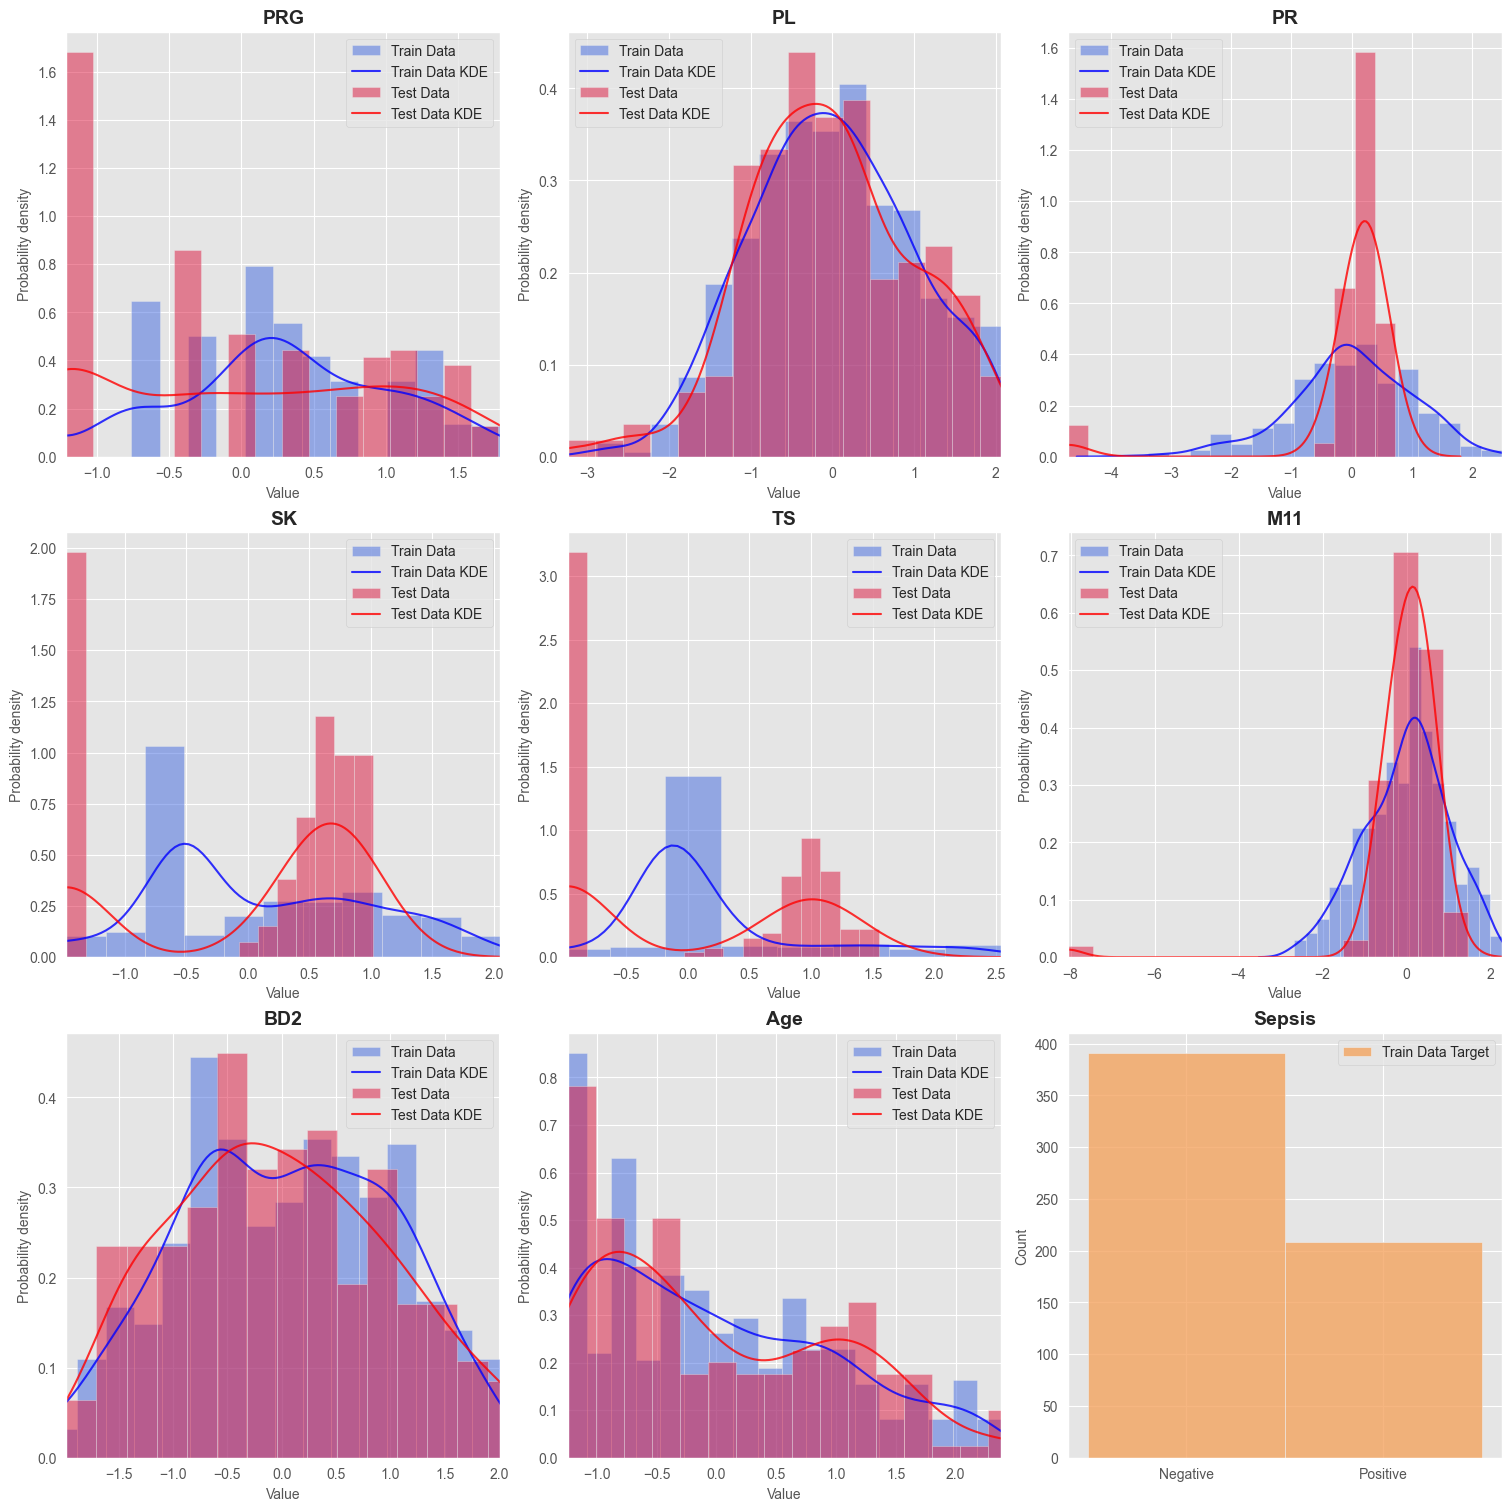

In [87]:
show_aggregate_distribution(df_train, df_test)

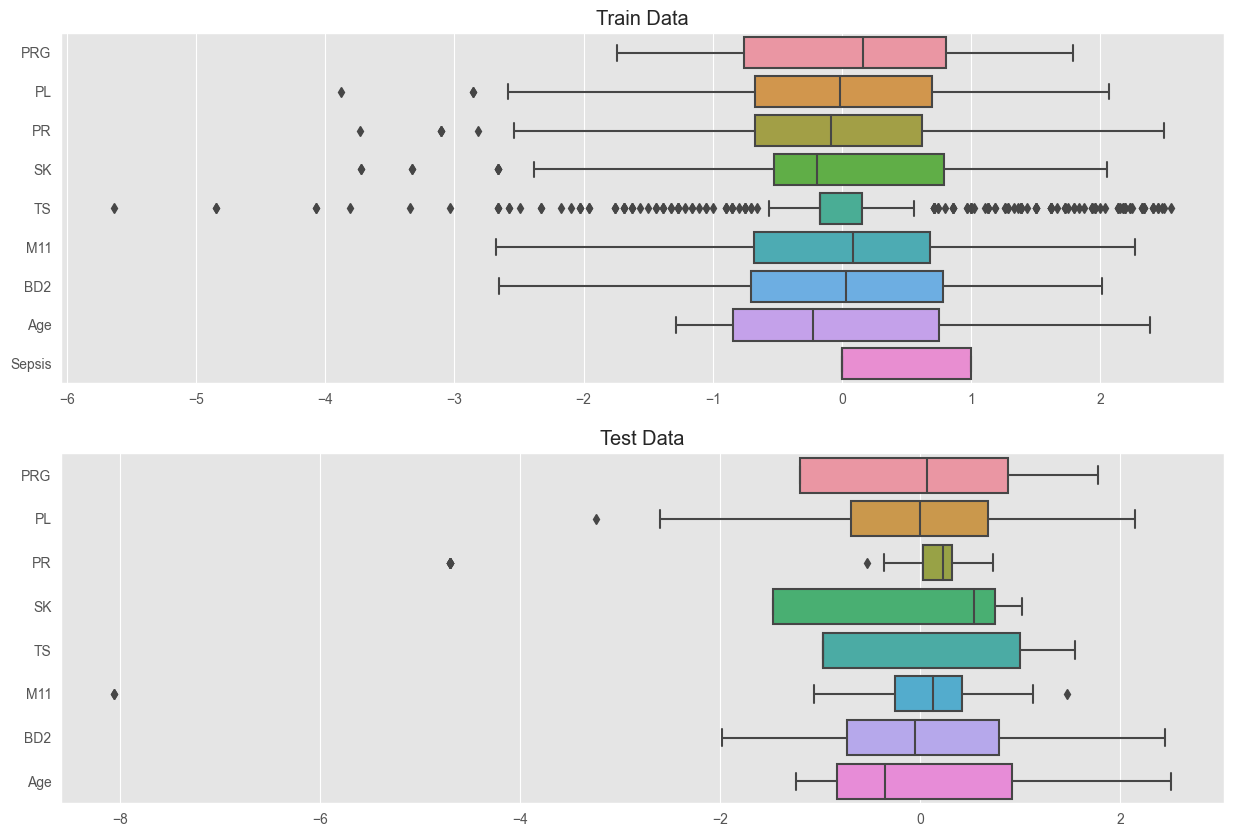

In [88]:
show_boxplots(df_train, df_test)

### 2.2. Dealing with Class Imbalance in Sepsis Target Column

As we have seen in [Step 1. EDA](../Step1.EDA.ipynb), there is a 2:1 class imbalance between $Negative$ and $Positive$ in the `Sepsis` target column. This is likely why our baseline model got better in predicting $Negative$ cases, as Logistic Regression assumes the class balance. To remedy this, we will synthesize new $Positive$ cases (up-sampling).

We only need to do this on the training data, and not the testing data.

In [89]:
negatives = df_train[df_train["Sepsis"] == 0]
positives = df_train[df_train["Sepsis"] == 1]

positives_up_sampled = resample(
    positives,
    replace=True,              # sample with replacement
    n_samples=len(negatives),  # 1:1 balanced
    random_state=0             # reproducible results
)

df_train = pd.concat([negatives, positives_up_sampled])

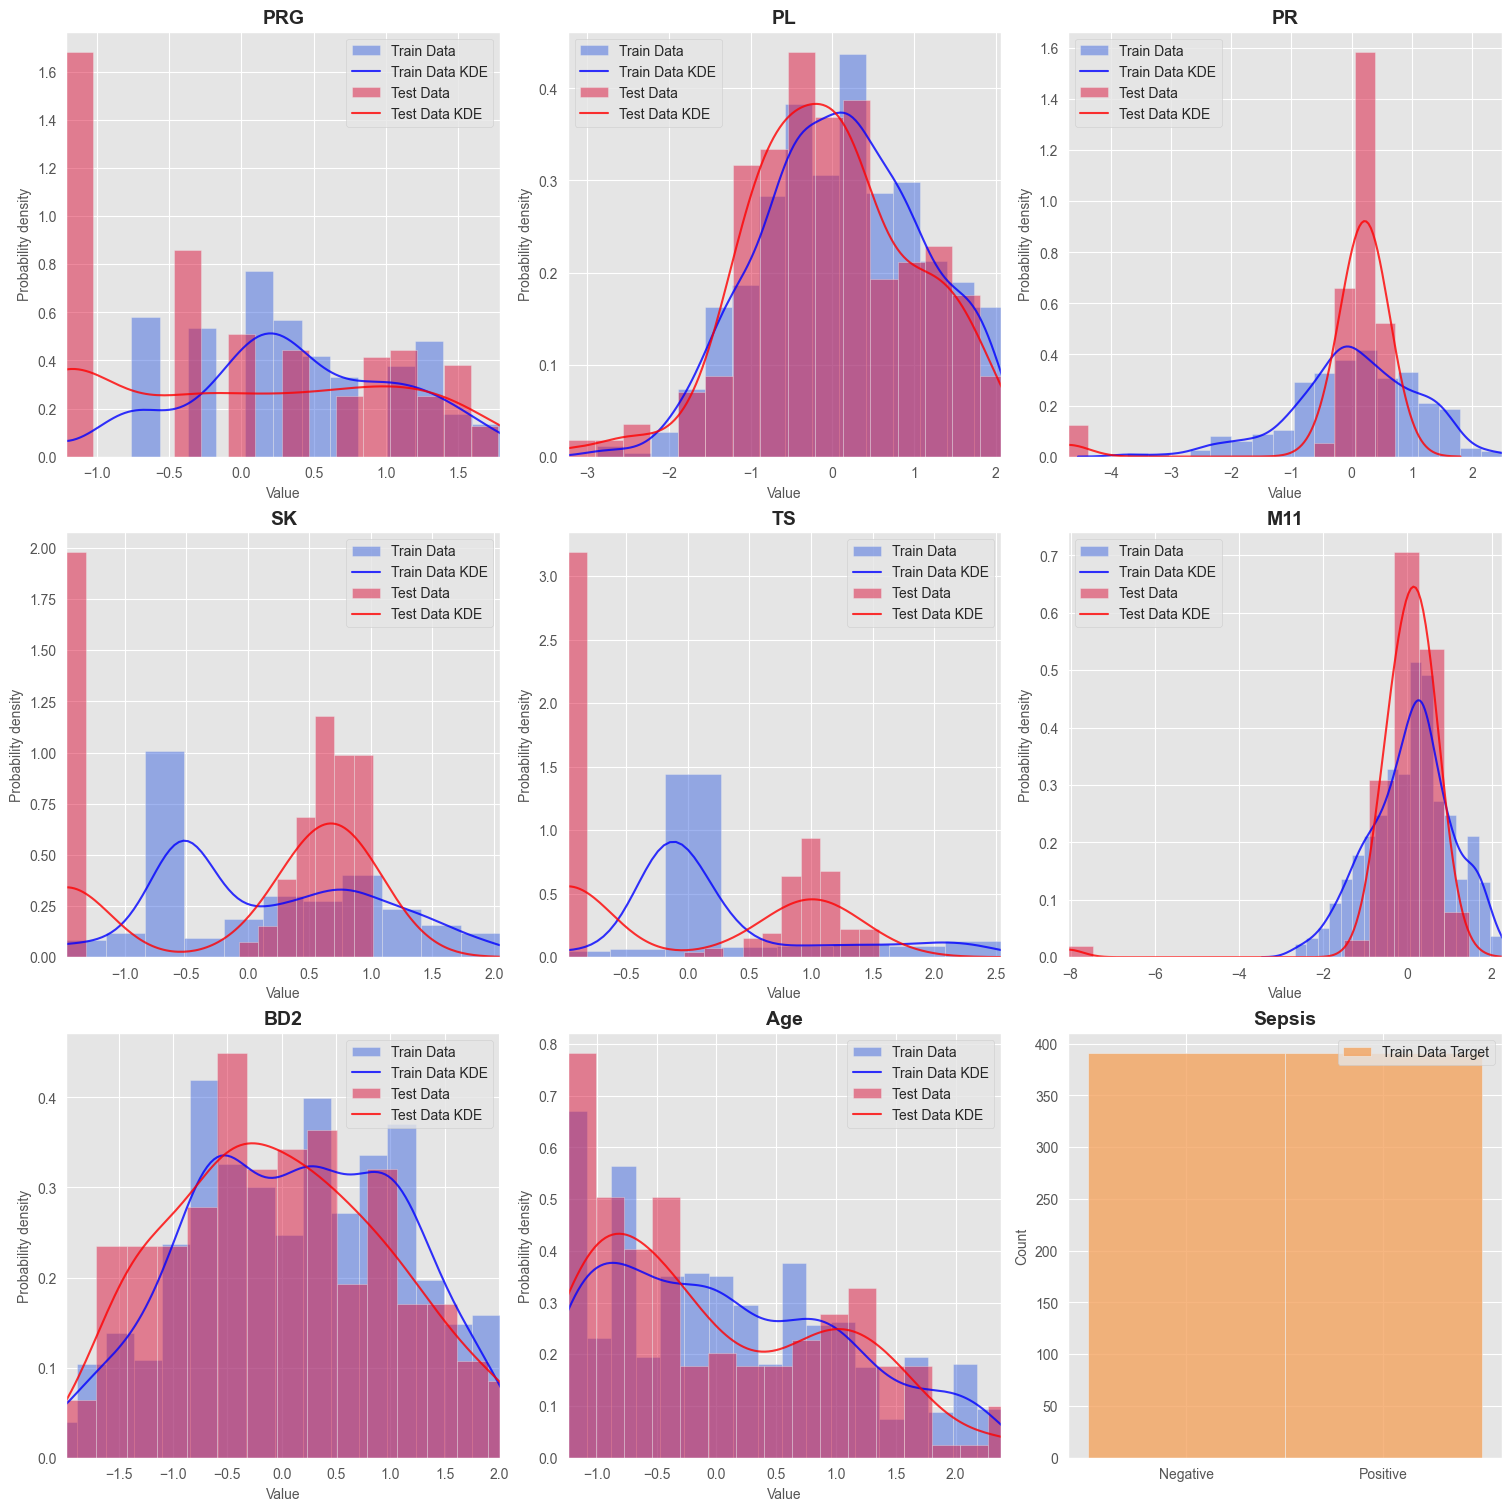

In [90]:
show_aggregate_distribution(df_train, df_test)

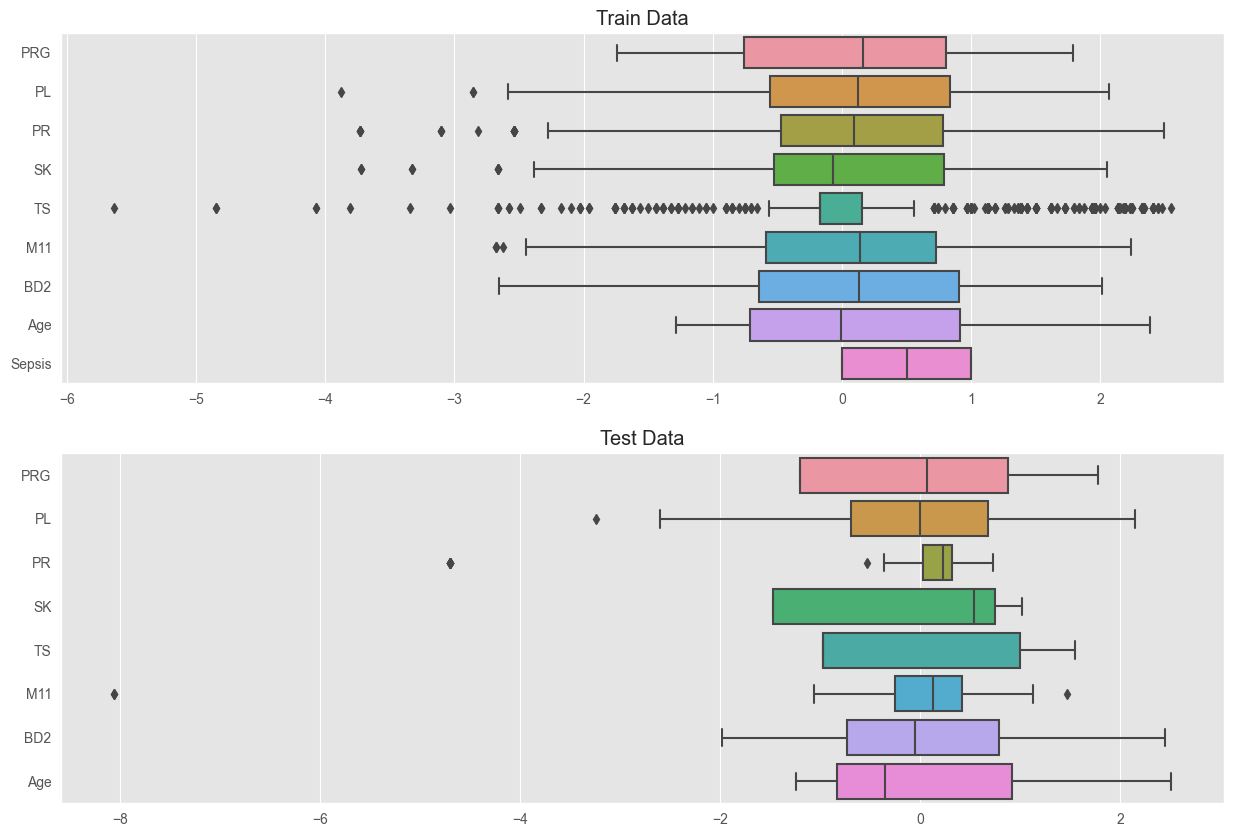

In [91]:
show_boxplots(df_train, df_test)

## 3. New Performance Measurement

Now let's see how our baseline model perform with this newly processed features:

In [92]:
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

train_X, test_X, train_y, test_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2
)

train_y = train_y["Sepsis"].values
test_y = test_y["Sepsis"].values


baseline_clf.fit(train_X, train_y)
pred_y = baseline_clf.predict(train_X)

print(f"{header(53, 'BASELINE MODEL PERFORMANCE')}\n{baseline_performance_report}")
print(f"{header(53, 'NEW MODEL PERFORMANCE')}\n{classification_report(train_y, pred_y)}")

╔═══════════════════════════════════════════════════╗
║            BASELINE MODEL PERFORMANCE             ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.80       316
         1.0       0.62      0.71      0.66       163

    accuracy                           0.75       479
   macro avg       0.73      0.74      0.73       479
weighted avg       0.76      0.75      0.76       479

╔═══════════════════════════════════════════════════╗
║               NEW MODEL PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75       309
         1.0       0.75      0.77      0.76       316

    accuracy                           0.76       625
   macro avg       0.76      0.76      0.76       625
weighted avg       0.76      0.76      0.76       625

